In [16]:
import cv2 as cv
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math

from Preprocessing import *
from EdgeDetection import *
from HoughTransform import *

In [17]:
pil_im = Image.open("lane_sample1.jpeg")
org = np.array(pil_im)

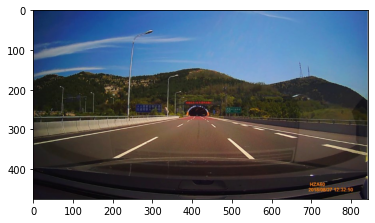

In [18]:
plt.imshow(org)

In [19]:
resized = resize(pil_im,512)
resized.shape, org.shape

((512, 908, 3), (475, 843, 3))

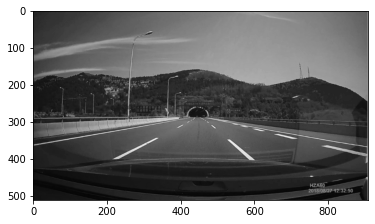

In [20]:
gray = rgb2gray(resized)
plt.imshow(gray,cmap='gray')

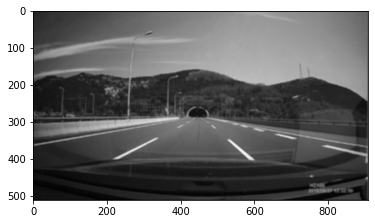

In [21]:
smooth = smoothing(gray)
plt.imshow(smooth,cmap='gray')

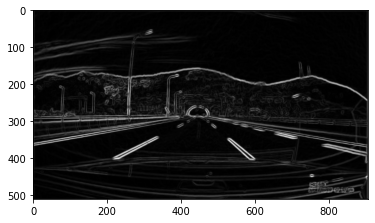

In [22]:
edge = sobel_edge_detector(smooth)
plt.imshow(edge,cmap='gray')

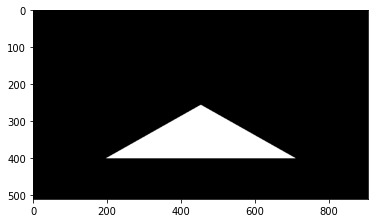

In [23]:
mask = fill_mask(edge)
plt.imshow(mask,cmap='gray')

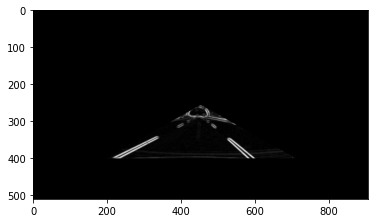

In [24]:
croped = apply_mask(edge, mask)
plt.imshow(croped,cmap='gray')

In [25]:
t = otsu_threshold(croped)
t

Number of bins = 301


89.5

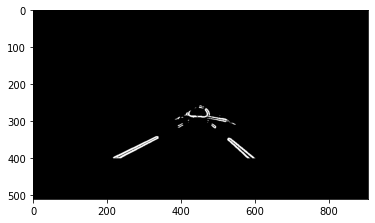

In [26]:
threshed = apply_threshold(croped, t)
plt.imshow(threshed,cmap='gray')

In [27]:
hough_space, point_stack = hough_lines(threshed, 50)

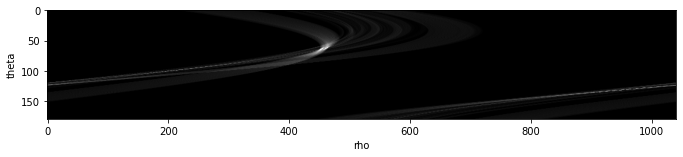

In [28]:
plt.figure(figsize = (20,2))
plt.imshow(hough_space, cmap='gray')
plt.xlabel('rho')
plt.ylabel('theta')
plt.show()

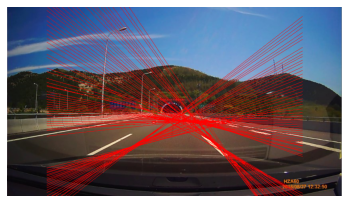

In [30]:
points_coord = [] #To store the coordinates of the lines
orig_line = org.copy()
h, w = org.shape[:2]

gradients = []
line_info = []

for i in point_stack:
    coeff = hough_intersect(i[0], i[1], org)
    if (len(coeff) > 1):
        m = coeff[0]
        b = coeff[1]
        y1 = m * 100 + b
        y2 = m * (w - 100) + b
        
        gradients.append(m)
        line_info.append((m, b))
        cv.line(orig_line, (100, int(y1)), (w - 100, int(y2)), (255,0,0))

fig = plt.imshow(orig_line)
plt.axis('off')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.show()

In [ ]:
histogram, bin_edges = np.histogram(gradients, bins=int(len(gradients)/3))

# configure and draw the histogram figure
plt.figure()
plt.title("Gradient Histogram")
plt.xlabel("gradient values")
plt.ylabel("frequency")

plt.plot(bin_edges[0:-1], histogram)  # <- or here
plt.show()

In [ ]:
# Exclude lines not from lanes
neg_lines = [line for line in line_info if line[0] < -0.3]
pos_lines = [line for line in line_info if line[0] > 0.3]

cleaned_lines_img = orig_img.copy()

for coeff in pos_lines:
    m = coeff[0]
    b = coeff[1]
    y1 = m * 100 + b
    y2 = m * (w - 100) + b
    cv.line(cleaned_lines_img, (100, int(y1)), (w - 100, int(y2)), (255,0,0))
    
for coeff in neg_lines:
    m = coeff[0]
    b = coeff[1]
    y1 = m * 100 + b
    y2 = m * (w - 100) + b
    cv.line(cleaned_lines_img, (100, int(y1)), (w - 100, int(y2)), (255,0,0))

fig = plt.imshow(cleaned_lines_img)
plt.show()

In [ ]:
# Compute Average Lines
averaged_lines_img = orig_img.copy()

total_m = 0
total_b = 0
for coeff in pos_lines:
    total_m += coeff[0]
    total_b += coeff[1]
    
pos_m = total_m / len(pos_lines)
pos_b = total_b / len(pos_lines)

total_m = 0
total_b = 0
for coeff in neg_lines:
    total_m += coeff[0]
    total_b += coeff[1]
    
neg_m = total_m / len(neg_lines)
neg_b = total_b / len(neg_lines)

y1 = pos_m * 100 + pos_b
y2 = pos_m * (w - 100) + pos_b
cv.line(averaged_lines_img, (100, int(y1)), (w - 100, int(y2)), (255,0,0))

y1 = neg_m * 100 + neg_b
y2 = neg_m * (w - 100) + neg_b
cv.line(averaged_lines_img, (100, int(y1)), (w - 100, int(y2)), (255,0,0))

fig = plt.imshow(averaged_lines_img)
plt.show()

In [ ]:
# Compute Vanishing Point
A = np.array([[-neg_m, 1], [-pos_m, 1]])
B = np.array([neg_b, pos_b])
C = np.linalg.solve(A, B)

vanished_img = orig_img.copy()


y1 = pos_m * (w - 100) + pos_b
cv.line(vanished_img, (int(C[0]), int(C[1])), (w - 100, int(y1)), (255,0,0))

y2 = neg_m * 100 + neg_b
cv.line(vanished_img, (100, int(y2)), (int(C[0]), int(C[1])), (255,0,0))

fig = plt.imshow(vanished_img)
plt.show()

# Color Detection

In [218]:
# # Mask is a zero matrix
# # fillMask fills an empty numpy array with 255 for pixels that fits inside the defined triangle
# def fillMaskColor(mask, h, w):
#     bottom_left = (h, 0)
#     middle = (int(h/2), int(w/2))
#     bottom_right = (h, w)
    
#     for x, row in enumerate(mask):
#         for y, col in enumerate(row):
#             # Applying equations to left_bound and right_bound
#             left_bound = (h - x) * middle[1] / middle[0]
#             right_bound = x * middle[1] / middle[0]
#             if y > left_bound and y < right_bound and x <= 400:
#                 mask[x][y][0] = 255 #red
#                 mask[x][y][1] = 255 #green
#                 mask[x][y][2] = 255 #blue
                
#     return mask

In [219]:
# For each non-zero pixel in mask, the corresponding pixel on image is kept (the rest of the pixels in mask is discarded)
def apply_mask_color(image, mask):
    for x, row in enumerate(mask):
        for y, col in enumerate(row):
            if mask[x][y][0] != 255:
                image[x][y][0] = 0
                image[x][y][1] = 0
                image[x][y][2] = 0
    return image

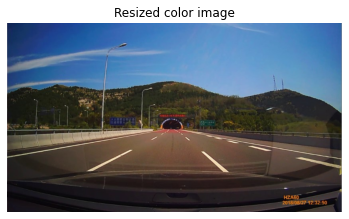

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


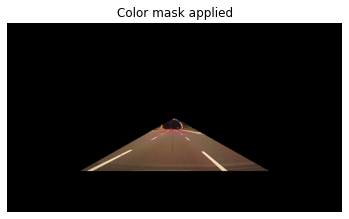

In [220]:
#add original image back
orig_img = np.array(pil_im)
plt.imshow(orig_img)
plt.title('Resized color image')
plt.axis('off')
plt.show()

rows = orig_img.shape[0]
cols = orig_img.shape[1]
colorMask = np.zeros((rows, cols, 3))
colorMask = fillMaskColor(colorMask, rows, cols)
plt.imshow(colorMask)
plt.title('Color mask')
plt.axis('off')
plt.show

croppedImageColor = apply_mask(orig_img, mask)
plt.imshow(croppedImageColor)
plt.title('Color mask applied')
plt.axis('off')
plt.show()

## RBG to HSV

In [221]:
def RGB_to_HSV(rgb):
    
    rows = rgb.shape[0]
    cols = rgb.shape[1]
    hsvImage = np.zeros((rows, cols, 3))
    
    for y in range(rows):
        for x in range(cols):
            redPrime = rgb[y,x,0] / 255
            greenPrime = rgb[y,x,1] / 255
            bluePrime = rgb[y,x,2] / 255
            cMax = max(redPrime, greenPrime, bluePrime)
            cMin = min(redPrime, greenPrime, bluePrime)
            delta = cMax - cMin
            
            #hue (color wheel (0 <= hue < 360))
            if delta == 0: #if there is no net hue (no dominating color) of a pixel, set the hue to 0
                hsvImage[y][x][0] = 0
            elif cMax == redPrime:
                hsvImage[y][x][0] = (60 * ((greenPrime - bluePrime) / delta) + 360) % 360 #reds are the first third of the color wheel
            elif cMax == greenPrime:
                hsvImage[y][x][0] = (60 * ((bluePrime - redPrime) / delta) + 120) % 360 #greens are the second third of the color wheel
            elif cMax == bluePrime:
                hsvImage[y][x][0] = (60 * ((redPrime - greenPrime) / delta) + 240) % 360 #blues are the third third of the color wheel
            
            #saturation (lower value is more white, higher value is more colored (0 <= saturation <= 1000))
            if cMax == 0: #black
                hsvImage[y][x][1] = 0
            else:
                hsvImage[y][x][1] = (delta / cMax) * 1000 #in permille
            
            #value (lower value is more black, higher value is more colored (0 <= saturation <= 1000))
            hsvImage[y][x][2] = cMax * 1000 #in permille
    
    return hsvImage

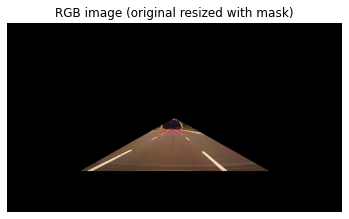

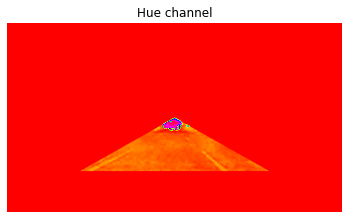

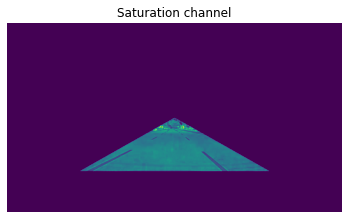

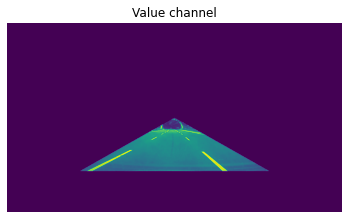

In [222]:
imHSV = RGB_to_HSV(croppedImageColor) #convert the RGB array to an HSV array

#extract hue, saturation, and value
hueImg = imHSV[:,:,0]
satImg = imHSV[:,:,1]
valImg = imHSV[:,:,2]

plt.imshow(croppedImageColor)
plt.title("RGB image (original resized with mask)")
plt.axis('off')
plt.show()

plt.imshow(hueImg, cmap = 'hsv')
plt.title("Hue channel")
plt.axis('off')
plt.show()

plt.imshow(satImg)
plt.title("Saturation channel")
plt.axis('off')
plt.show()

plt.imshow(valImg)
plt.title("Value channel")
plt.axis('off')
plt.show()

## Histogram hue, saturation, and value

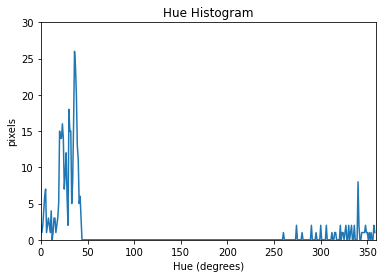

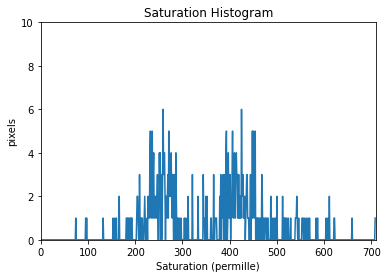

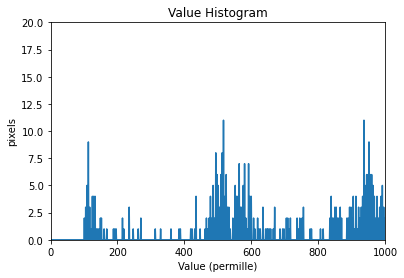

In [229]:
#use only the pixels that are both in the cropped section and on the lines
croppedHue = []
for y in range(rows):
    for x in range(cols):
        if (colorMask[y][x][0] != 0): #unmasked region
            yLine1 = int(neg_m * x + neg_b) #find lane line y value corresponding to the x value for the left lane line
            yLine2 = int(pos_m * x + pos_b) #find lane line y value corresponding to the x value for the right lane line
            if ((y == yLine1) or (y == yLine2)): #pixel on line
                    croppedHue.append(hueImg[y][x])
croppedHue = np.array(croppedHue)

maxHueValue = int(np.amax(croppedHue)) + 1

hueHistogram, hueBinEdges = np.histogram(croppedHue, bins=maxHueValue, range=(0,maxHueValue))
# configure and draw the histogram figure
plt.figure()
plt.title("Hue Histogram")
plt.xlabel("Hue (degrees)")
plt.ylabel("pixels")
plt.xlim([0, maxHueValue])
plt.ylim([0, 30]) # must be changed manually after generating once for better visual analysis

plt.plot(hueBinEdges[0:-1], hueHistogram)  # <- or here
plt.show()

#use only the cropped section
croppedSat = []
for y in range(rows):
    for x in range(cols):
        if (colorMask[y][x][0] != 0): #unmasked region
            yLine1 = int(neg_m * x + neg_b) #find lane line y value corresponding to the x value for the left lane line
            yLine2 = int(pos_m * x + pos_b) #find lane line y value corresponding to the x value for the right lane line
            if ((y == yLine1) or (y == yLine2)): #pixel on line
                croppedSat.append(satImg[y][x])
croppedSat = np.array(croppedSat)

maxSatValue = int(np.amax(croppedSat)) + 1

satHistogram, satBinEdges = np.histogram(croppedSat, bins=maxSatValue, range=(0,maxSatValue))
# configure and draw the histogram figure
plt.figure()
plt.title("Saturation Histogram")
plt.xlabel("Saturation (permille)")
plt.ylabel("pixels")
plt.xlim([0, maxSatValue])
plt.ylim([0, 10]) # must be changed manually after generating once for better visual analysis

plt.plot(satBinEdges[0:-1], satHistogram)  # <- or here
plt.show()

#use only the cropped section
croppedVal = []
for y in range(rows):
    for x in range(cols):
        if (colorMask[y][x][0] != 0): #unmasked region
            yLine1 = int(neg_m * x + neg_b) #find lane line y value corresponding to the x value for the left lane line
            yLine2 = int(pos_m * x + pos_b) #find lane line y value corresponding to the x value for the right lane line
            if ((y == yLine1) or (y == yLine2)): #pixel on line
                croppedVal.append(valImg[y][x])
croppedVal = np.array(croppedVal)

maxValValue = int(np.amax(croppedVal)) + 1

valHistogram, valBinEdges = np.histogram(croppedVal, bins=maxValValue, range=(0,maxValValue))
# configure and draw the histogram figure
plt.figure()
plt.title("Value Histogram")
plt.xlabel("Value (permille)")
plt.ylabel("pixels")
plt.xlim([0, maxValValue])
plt.ylim([0, 20]) # must be changed manually after generating once for better visual analysis

plt.plot(valBinEdges[0:-1], valHistogram)  # <- or here
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<function matplotlib.pyplot.show(close=None, block=None)>

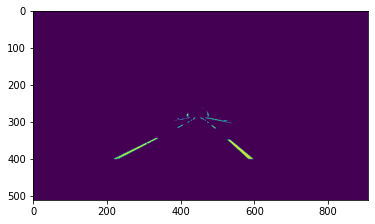

In [232]:
#Temporary thresholding for research purposes
for y in range(rows):
    for x in range(cols):
        if valImg[y][x] < 800:
            imHSV[y][x][2] = 0
            valImg[y][x] = 0

plt.imshow(imHSV)
plt.show

plt.imshow(valImg)
plt.show

## Detection

In [230]:
def getColor(hue, saturation, value):
    if value < 500:
        return "darkColor"
    elif saturation <= 200:
        return "white"
    elif hue <= 300: #most pixels have a very low hue, so this must be fixed since it's counting the pavement
        return "red"
    elif hue <= 800:
        return "yellow"

There are 0 yellow pixels on the lane lines in the mask.
There are 10 white pixels on the lane lines in the mask.
The color of the lane markings is white.


<function matplotlib.pyplot.show(close=None, block=None)>

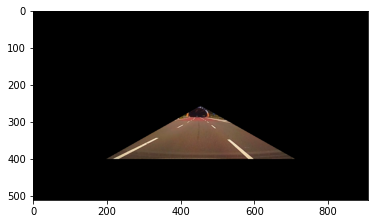

In [231]:
#currently can only detect yellow and white since it treats the unmarked pavement as red which will be fixed later, needs to be tested with multiple images

#number of pixels with that color
yellows = 0
whites = 0
reds = 0

for y in range(rows):
    for x in range(cols):
        if (colorMask[y][x][0] != 0): #unmasked region
            yLine1 = int(neg_m * x + neg_b) #find lane line y value corresponding to the x value for the left lane line
            yLine2 = int(pos_m * x + pos_b) #find lane line y value corresponding to the x value for the right lane line
            if ((y == yLine1) or (y == yLine2)): #pixel on line
                pixelColor = getColor(hueImg[y][x], satImg[y][x], valImg[y][x]) #get the color (string) of that pixel
                if pixelColor == "yellow":
                    yellows += 1
                elif pixelColor == "white":
                    whites += 1
                #elif pixelColor == "red":
                    #reds += 1

#decide the most dominant color
if yellows == max(yellows, whites, reds):
    laneColor = "yellow"
elif reds == max(yellows, whites, reds):
    laneColor = "red"
elif whites == max(yellows, whites, reds):
    laneColor = "white"


#xTest = 330
#yTest = int(m1 * xTest + c1)
#print(f'{croppedImageColor[yTest][xTest][0]} {croppedImageColor[yTest][xTest][1]} {croppedImageColor[yTest][xTest][2]}')
print(f'There are {yellows} yellow pixels on the lane lines in the mask.')
print(f'There are {whites} white pixels on the lane lines in the mask.')
#print(f'There are {reds} red pixels on the lane lines in the mask.')
print(f'The color of the lane markings is {laneColor}.')

plt.imshow(croppedImageColor)
plt.axis('on')
plt.show